In [43]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import nbimporter
import time
from OptiEngine import FEM_2D, Config, Timer, optimize

In [44]:
class Timer():
    def __init__(self):
        pass
    
    def start(self):
        self.start_time = time.time()
        
    def end_print(self, print_row):
        end_time = time.time()
        time_passed = round(end_time - self.start_time, 4)
        
        print(f'{print_row} {time_passed} sec')
        
    def time_passed(self):
        end_time = time.time()
        time_passed = round(end_time - self.start_time, 8)
        
        return time_passed

In [2]:
def load_data(path, name_pattern, n_samples):
    pattern = f'{path}\\{name_pattern}_'
    
    # Loading first sample
    samples = np.loadtxt(f'{pattern}{0}_result.txt')
    tasks = np.loadtxt(f'{pattern}{0}_task.txt')
    
    for sample_i in range(1, n_samples):
        new_sample = np.loadtxt(f'{pattern}{sample_i}_result.txt')
        new_task = np.loadtxt(f'{pattern}{sample_i}_task.txt')
        samples = np.concatenate([samples, new_sample], axis = 0)
        tasks = np.concatenate([tasks, new_task], axis = 0)
        
    return (samples.reshape(n_samples, 29, 29), tasks.reshape(n_samples, 30, 30))

In [3]:
def shuffle_data(samples, tasks):
    random_index = np.random.randint(0, samples.shape[0], size = samples.shape[0])
    
    samples_shuffled = samples[random_index]
    tasks_shuffled = tasks[random_index]
    
    return (samples_shuffled, tasks_shuffled)

In [4]:
def gen_batches(samples, tasks, batch_size):
    batches = []
    n_samples = samples.shape[0]
    n_batches = int((n_samples-1) / batch_size)
    
    samples_shuffled, tasks_shuffled = shuffle_data(samples, tasks)
    
    for i in range(n_batches):
        batch_samp = samples_shuffled[i*batch_size]
        batch_task = tasks_shuffled[i*batch_size]
        
        for j in range(1, batch_size):
            batch_samp = np.concatenate((batch_samp, samples_shuffled[i*batch_size + j]), axis = 0)
            batch_task = np.concatenate((batch_task, tasks_shuffled[i*batch_size + j]), axis = 0)
        
        batch_samp = batch_samp.reshape(batch_size, 29, 29)
        batch_task = batch_task.reshape(batch_size, 30, 30)
            
        batches.append((batch_samp, batch_task))
    return batches

In [32]:
class LinearTopologyGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_1 = nn.Linear(in_features = 900, out_features = 1024)
        self.linear_2 = nn.Linear(in_features = 1024, out_features = 1024)
        self.linear_3 = nn.Linear(in_features = 1024, out_features = 2048)
        self.linear_4 = nn.Linear(in_features = 2048, out_features = 2048)
        self.linear_5 = nn.Linear(in_features = 2048, out_features = 3072)
        self.linear_6 = nn.Linear(in_features = 3072, out_features = 2048)
        self.linear_7 = nn.Linear(in_features = 2048, out_features = 841)
        
        self.activ = nn.LeakyReLU(0.15)
        
    def forward(self, x):
        x = self.linear_1(x)
        x = self.activ(x)
        x = self.linear_2(x)
        x = self.activ(x)
        x = self.linear_3(x)
        x = self.activ(x)
        x = self.linear_4(x)
        x = self.activ(x)
        x = self.linear_5(x)
        x = self.activ(x)
        x = self.linear_6(x)
        x = self.activ(x)
        x = self.linear_7(x)
        
        return x

In [19]:
def train_linear(model, n_epochs, learning_rate, origin_samples, origin_tasks, batch_size):
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    loss_func = nn.MSELoss()
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}')
        for batch in gen_batches(origin_samples, origin_tasks, batch_size):
            samples, tasks = batch
            
            samples = torch.FloatTensor(samples).reshape(-1, 841)
            tasks = torch.FloatTensor(tasks).reshape(-1, 900)
            
            predict = model(tasks)
            loss = loss_func(predict, samples)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [7]:
path = 'C:\\Users\\mihai\\Desktop\\Unik\\4 курс\\Оптимизация\\Train_Data\\Square_Bucket_1'
name_pattern = 'bucket1'
n_samples = 2640

In [8]:
samples, tasks = load_data(path, name_pattern, n_samples)

Example of optimized topology:


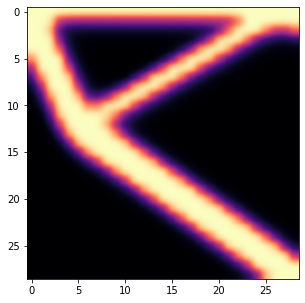

In [9]:
fig, axes = plt.subplots(figsize = (5,5))
axes.imshow(samples[0], interpolation = 'gaussian', cmap = 'magma')
print('Example of optimized topology:')

In [33]:
model = LinearTopologyGenerator()

In [34]:
train_linear(model, 50, (1e-3)/2, samples, tasks, 32)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


In [47]:
train_linear(model, 15, (1e-4)/2, samples, tasks, 32)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15


Neural Network design time:  0.006 sec


Text(0.5, 1.0, 'NN solution')

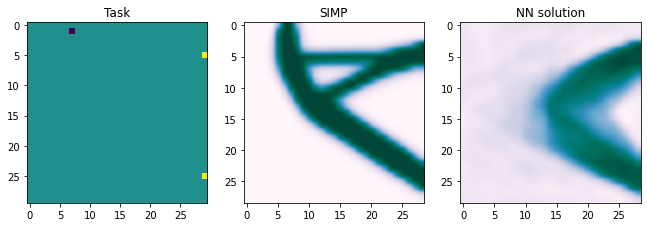

In [52]:
sample_i = 0
model.eval()
task = tasks[sample_i]

custom_task = np.zeros((30, 30))
custom_task[1][7] = -1
custom_task[5][29] = 1
custom_task[25][29] = 1

config = Config()

nx = 30
ny = 30

config.nx = nx
config.ny = ny

config.vol_frac = 0.3
config.penalize = 3

config.dense_delta = 0.01
config.max_iter = 40

config.E0 = 1
config.E_void = 1e-9

config.filter_r = 1.5
config.move = 0.2

config.fem_save_iters = [1]

FEM_solver = FEM_2D(config.nx, config.ny, config.filter_r)

FEM_solver.fix_node(5, 29, True, True)
FEM_solver.fix_node(25, 29, True, True)
FEM_solver.apply_load(1, 7, 0, -1)

FEM_solver.form_elements()
config.H, config.sH = FEM_solver.prepare_filter()
xPhys_opt = optimize(FEM_solver, config, False, False)

ey = ny - 1
ex = nx - 1

x_matrix = np.zeros((ey, ex))
for col in range(ex):
    for row in range(ey):
        x_matrix[row][col] = xPhys_opt[col*ey + row]

fig, axes = plt.subplots(1, 3, figsize = (11,11))
axes[0].imshow(custom_task)
axes[0].set_title('Task')

axes[1].imshow(x_matrix, interpolation = 'gaussian', cmap = 'PuBuGn')
axes[1].set_title('SIMP')

timer = Timer()
timer.start()
solution = model(torch.FloatTensor(custom_task.reshape(900)).unsqueeze(0)).detach().reshape(29,29)
timer.end_print('Neural Network design time: ')
axes[2].imshow(solution, interpolation = 'gaussian', cmap = 'PuBuGn')
axes[2].set_title('NN solution')